# Ganによる異常検知

In [1]:
!gpustat

s2                   Tue Apr 21 15:00:14 2020  440.44
[0] Quadro RTX 8000  | 51'C,   0 % |  2597 / 48601 MB | taoli(2583M)
[1] Quadro RTX 8000  | 26'C,   0 % |    12 / 48601 MB |
[2] Quadro RTX 8000  | 25'C,   0 % |    12 / 48601 MB |
[3] Quadro RTX 8000  | 25'C,   0 % |  1765 / 48601 MB | inoue(1753M)
[4] Quadro RTX 8000  | 56'C,  68 % |  5178 / 48601 MB | taoli(2581M) taoli(2581M)
[5] Quadro RTX 8000  | 50'C,  79 % |  2595 / 48601 MB | taoli(2581M)
[6] Quadro RTX 8000  | 47'C,   0 % |  2595 / 48601 MB | taoli(2581M)
[7] Quadro RTX 8000  | 53'C,  71 % |  2595 / 48601 MB | taoli(2581M)


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [3]:
# パッケージのimport
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms
%config IPCompleter.greedy=True

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# device = "cpu"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

## 6-1 GANによる異常画像検知のメカニズム

### Ganを用いた異常画像検知の必要性
異常画像検知は医療の現場や，製造業の生産ラインで利用される．従来では熟練者の経験で行われていたものをマシンに行わせる．
従来のルールベースの手法ではうまくいかなったものがディープラーニングの導入によって補助・代替できる可能性がある．

**しかしディープラーニングを用いた異常画像検知の問題点としては正常画像の数に対して異常画像の数が圧倒的に少ないことである．** そこで本節では正常画像のみでディープラーニングを行って異常画像を検出できるアルゴリズムの構築することに取り組む．

### AnoGANの概要
最も自然な考えとしては正常画像のみを生成するGANを構築して，そのDiscriminatorに対してテストしたい画像を入力することで教師画像か偽画像かを判断させる方法で，教師画像と判断されればこれは正常画像であり，偽画像と判断されればこれは異常画像として検知される．しかしこのような方法では実際にはうまくいかないらしい．

実際にはGeneratorも用いて異常検知させる．大まかには以下の手順で行う．
1. **まず通常のGANと同様に正常画像のみでGANを構築する．**
2. **Generatorに入力する生成ノイズzの中で最もテストしたい画像に近い画像を生成できるzを決定する．**
3. **その決定したzを用いて生成した画像とテストしたい画像がどれくらい似ているかで異常検知を行う．**

次節ではこれらの手順に加えて以下についても理解していく．
- Discriminatorはどこで用いるのか
- 生成ノイズzの最適値はどのように決定するのか
- 生成画像とテスト画像の似ている度合いはどのように判断するのか

## 6-2 AnoGANの実装と異常検知の実施

### DCGANの学習
AnoGANのGANには前節で実装したDCGANを用いる．

DCGANに対してAnoGAN用にDiscriminatorの最後の出力の１つ手前の層の特徴量も出力するように変更する．
この特徴量を用いて生成ノイズの最適値を求める．

In [6]:
class Generator(nn.Module):
    
    def __init__(self, z_dim = 20, image_size=64):
        super(Generator, self).__init__()
        
        # ここで out_channels = image_size*8に特別な意味は？
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(z_dim, image_size*8, kernel_size=4, stride=1),
            nn.BatchNorm2d(image_size*8),
            nn.ReLU(inplace=True))
        
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size*8, image_size*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size*4),
            nn.ReLU(inplace=True))
            
        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(image_size*4, image_size*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size*2),
            nn.ReLU(inplace=True))
              
        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(image_size*2, image_size, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True))
        
        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh())
        # 白黒なので出力は1チャネル
        
        
    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)
        
        return out

In [7]:
class Discriminator(nn.Module):
    
    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, image_size, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size, image_size*2, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size*2, image_size*4, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size*4, image_size*8, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)
        
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        """
        生成ノイズzを決定するための特徴量を出力する
        """
        feature = out
        feature = feature.view(feature.size()[0], -1) # 二次元に変換する
        
        out = self.last(out)
        
        return out , feature

### 正常画像のみで学習済みのGANを用意する
ここでは学習済みの重みをロードすることを想定する．

In [8]:
import sys, os
sys.path.append('./../5_gan_generation/')

G = Generator(z_dim=20, image_size=64)
D = Discriminator(z_dim=20, image_size=64)

G.to(device)
D.to(device)

g_weights = torch.load("../5_gan_generation/weights/dcgan_g_600.pth",
                        map_location={'cuda:0': 'cpu'})
d_weights = torch.load("../5_gan_generation/weights/dcgan_d_600.pth",
                        map_location={'cuda:0': 'cpu'})

G.load_state_dict(g_weights)
D.load_state_dict(d_weights)
G_update = G  # 実際には同じもの ここは便宜上名前を変えている
D_update = D

### AnoGANの生成ノイズzの求め方
初期値としてはzを乱数を用いて生成して，損失関数がzによってどのように変化するかをPyTorchの自動微分機能を用いて実装することができる．

損失関数は生成した画像とテスト画像とのチャネルごとのピクセルレベルの差の絶対値の総和によって計算する．

In [9]:
# device = "cpu"
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 生成ノイズの初期乱数
z = torch.randn(5,20).to(device) #5=minibatch_size,  20 = z_dim
z = z.view(z.size()[0], z.size()[1],1,1)
           
z.requires_grad = True

z_optimizer = torch.optim.Adam([z], lr=1e-3)

あとはこのzについての```loss```を実装すれば，```loss.backward()```や```z_optimizer.step()```で生成ノイズを求めることができる

### AnoGANの損失関数
- residual loss
- discrimination loss

各チャネルごとにピクセルレベルの差を総和する．これをAnoGANでは **residual loss** と言う．

しかしこのresidual lossだけでは学習が進みにくいので，テスト画像や生成した画像をDiscriminatorに入力して得る出力層の１つ手前の層の特徴量を利用する．この特徴量におけるテスト画像と生成画像のピクセルレベルでの差を計算し，この計算した値を **discrimination loss** と言う．これらを用いて損失関数```loss```は
$$
loss = (1-\lambda)\times residual\  loss + \lambda \times discrimination\  loss
$$

AnoGAN論文では$\lambda$は0.1に設定されている

In [57]:
def Anomaly_score(x, fake_img, D, Lambda=0.1):
    
    # テスト画像xと生成画像fake_imgのピクセルレベルの差のabsをミニバッチごとに総和
    residual_loss = torch.abs(x-fake_img)
    residual_loss = residual_loss.view(residual_loss.size()[0], -1)
    residual_loss = torch.sum(residual_loss, dim=1)
    
    # テスト画像と生成画像をDiscriminatorに判断させる
    _, x_feature = D(x)
    _, G_feature = D(fake_img)
    
    # discrimination_loss を residual_loss と同様に求める
    discrimination_loss = torch.abs(x_feature - G_feature)
    discrimination_loss = discrimination_loss.view(discrimination_loss.size()[0], -1)
    discrimination_loss = torch.sum(discrimination_loss, dim=1)
    
    # mini_batchごとにlossを求める
    loss_each = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    
    # mini_batch全部の損失を求める
    total_loss = torch.sum(loss_each)
    
    return total_loss, loss_each, residual_loss

### AnoGANの学習の実装と異常検知の実施
正常な画像としてmnistの[7, 8] を，異常画像としてmnistの[2]を入力する

In [51]:
# DataLoaderの作成

def make_test_datapath_list():
    
    train_img_list = list()
    
    for img_idx in range(5):
        img_path = "./data/test/img_7_" + str(img_idx) + ".jpg"
        train_img_list.append(img_path)
        
        img_path = "./data/test/img_8_" + str(img_idx) + ".jpg"
        train_img_list.append(img_path)
        
        img_path = "./data/test/img_2_" + str(img_idx) + ".jpg"
        train_img_list.append(img_path)
    
    return train_img_list


class ImageTransform():
    """
    画像クラスの前処理
    """
    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
    
    def __call__(self, img):
        return self.data_transform(img)
    

class GAN_Img_Dataset(data.Dataset):
    """
    画像のDataset
    """
    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform
            
    def __len__(self):
        """画像の枚数を返す"""
        return len(self.file_list)
    
    def __getitem__(self,index):
        """前処理をした画像のTensor形式のデータを取得"""
        
        img_path = self.file_list[index]
        img = Image.open(img_path) #H,W,C
        
        # 前処理
        img_transformed = self.transform(img)
        
        return img_transformed

In [52]:
# ファイルリストの作成
test_img_list = make_test_datapath_list()

# Datasetを作成
mean = (0.5,)
std = (0.5,)
test_dataset = GAN_Img_Dataset(
    file_list=test_img_list, transform = ImageTransform(mean, std))

In [53]:
# DataLoaderの作成

batch_size = 5

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True)

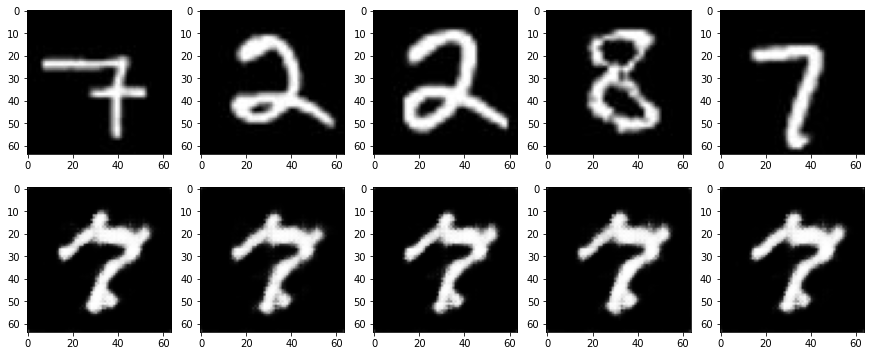

In [64]:
# 生成画像と訓練データを可視化する
# 本セルは何度か実行し直しています。

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 入力の乱数生成
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)
fake_images = G_update(fixed_z.to(device))

# 訓練データ
batch_iterator = iter(test_dataloader)  # イテレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す


# 出力
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段に訓練データを
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    # 下段に生成データを表示する
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')

In [62]:
# 異常検知したい画像
x = imges[0:5]
x = x.to(device)

# 生成ノイズの初期乱数
z = torch.randn(5,20).to(device) #5=minibatch_size,  20 = z_dim
z = z.view(z.size(0), z.size(1),1,1)
           
z.requires_grad = True

z_optimizer = torch.optim.Adam([z], lr=1e-3)

# zを求める
for epoch in range(5000+1):
    fake_img = G(z)
    loss, _, _ = Anomaly_score(x, fake_img, D_update, Lambda=0.1)
    
    z_optimizer.zero_grad()
    loss.backward()
    z_optimizer.step()
    
    if(epoch) % 1000 == 0:
        print("epoch {} || loss_total:{: .0f} ".format(epoch, loss.item()))

epoch 0 || loss_total: 6907 
epoch 1000 || loss_total: 6344 
epoch 2000 || loss_total: 6081 
epoch 3000 || loss_total: 5960 
epoch 4000 || loss_total: 5781 
epoch 5000 || loss_total: 5763 


total loss： [1144. 1177. 1316. 1093. 1033.]


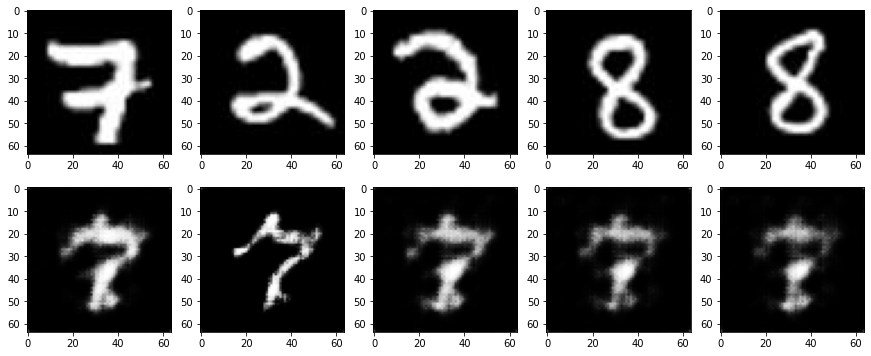

In [63]:
# 画像を生成
fake_img = G_update(z)

# 損失を求める
loss, loss_each, residual_loss_each = Anomaly_score(
    x, fake_img, D_update, Lambda=0.1)

# 損失の計算。トータルの損失
loss_each = loss_each.cpu().detach().numpy()
print("total loss：", np.round(loss_each, 0))

# 画像を可視化
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段にテストデータを
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    # 下段に生成データを表示する
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_img[i][0].cpu().detach().numpy(), 'gray')